In [1]:
# Capstone project for the Coursera IBM Data Science Professional Certificate

In [2]:
# import relevant libraries

import numpy as np 

import pandas as pd 
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


In [3]:
# send GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [4]:
# parse html data into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [5]:
# create 3 lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [6]:
# find the table
soup.find('table').find_all('tr')

# find all the rows of the table
soup.find('table').find_all('tr')

# for each row of the table, find all the table data
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')

In [7]:
# populate lists with data 
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text.rstrip('\n'))
        boroughList.append(cells[1].text.rstrip('\n'))
        neighborhoodList.append(cells[2].text.rstrip('\n')) # avoid new lines in neighborhood cell

In [8]:
# create a new DataFrame using the 3 lists
toronto_df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [9]:
# drop cells with unassigned borough
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
toronto_df_dropna.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [10]:
# group neighborhoods by borough
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
# for Neighborhood="Not assigned", set value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_grouped[toronto_df_grouped["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Parkview Hill, Woodbine Gardens"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Wexford, Maryvale"
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har..."


In [13]:
# print the number of rows of the cleaned dataframe
toronto_df_grouped.shape

(103, 3)

In [14]:
# load the geospatial coordinates from csv
coordinates = pd.read_csv("C:\\Users\\aritc\\Documents\\Coursera\\Capstone\\Geospatial_Coordinates.csv")
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
# rename column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
# merge dataframes on column "PostalCode"
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
toronto_df_new.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [17]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_new[toronto_df_new["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420


In [18]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [19]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [20]:
# filter borough names that contain the word Toronto
borough_names = list(toronto_df_new.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

In [21]:
# create a new DataFrame with only boroughs that contain the word Toronto
toronto_df_new = toronto_df_new[toronto_df_new['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
print(toronto_df_new.shape)
toronto_df_new.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [22]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [121]:
# define Foursquare Credentials and Version
CLIENT_ID = '******' # your Foursquare ID
CLIENT_SECRET = '******' # your Foursquare Secret
VERSION = '20210202' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ******
CLIENT_SECRET:******


In [24]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['PostalCode'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [25]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1588, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [26]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhood,,,,,,
M4E,East Toronto,The Beaches,4,4,4,4,4,4
M4K,East Toronto,"The Danforth West, Riverdale",42,42,42,42,42,42
M4L,East Toronto,"India Bazaar, The Beaches West",21,21,21,21,21,21
M4M,East Toronto,Studio District,36,36,36,36,36,36
M4N,Central Toronto,Lawrence Park,3,3,3,3,3,3
M4P,Central Toronto,Davisville North,8,8,8,8,8,8
M4R,Central Toronto,"North Toronto West, Lawrence Park",19,19,19,19,19,19
M4S,Central Toronto,Davisville,35,35,35,35,35,35
M4T,Central Toronto,"Moore Park, Summerhill East",2,2,2,2,2,2


In [27]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 227 uniques categories.


In [28]:
venues_df['VenueCategory'].unique()[:50]

array(['Trail', 'Health Food Store', 'Pub', 'Neighborhood',
       'Cosmetics Shop', 'Greek Restaurant', 'Italian Restaurant',
       'Ice Cream Shop', 'Yoga Studio', 'Brewery',
       'Fruit & Vegetable Store', 'Restaurant', 'Pizza Place',
       'Juice Bar', 'Bookstore', 'Furniture / Home Store', 'Dessert Shop',
       'Bubble Tea Shop', 'Spa', 'Coffee Shop', 'Tibetan Restaurant',
       'Bakery', 'Indian Restaurant', 'Grocery Store',
       'Caribbean Restaurant', 'Café', 'Lounge', 'Frozen Yogurt Shop',
       'Liquor Store', 'American Restaurant', 'Gym', 'Fish & Chips Shop',
       'Fast Food Restaurant', 'Sushi Restaurant', 'Park', 'Pet Store',
       'Steakhouse', 'Movie Theater', 'Sandwich Place', 'Intersection',
       'Food & Drink Shop', 'Fish Market', 'Seafood Restaurant',
       'Gay Bar', 'Cheese Shop', 'Comfort Food Restaurant',
       'Middle Eastern Restaurant', 'Stationery Store', 'Thai Restaurant',
       'Coworking Space'], dtype=object)

In [29]:
# Group venue categories by type

L1 = ['Greek Restaurant','Italian Restaurant','Restaurant','Tibetan Restaurant','Caribbean Restaurant','American Restaurant','Sushi Restaurant','Steakhouse','Seafood Restaurant','Middle Eastern Restaurant', 'Thai Restaurant','Latin American Restaurant', 'Mexican Restaurant','Chinese Restaurant','Vietnamese Restaurant','Japanese Restaurant', 'Taiwanese Restaurant','Theme Restaurant', 'Ramen Restaurant','Ethiopian Restaurant','Mediterranean Restaurant', 'Korean Restaurant', 'French Restaurant','Asian Restaurant','Modern European Restaurant','New American Restaurant','Vegetarian / Vegan Restaurant','Moroccan Restaurant', 'Belgian Restaurant', 'Portuguese Restaurant','Colombian Restaurant', 'Gluten-free Restaurant','Brazilian Restaurant', 'Filipino Restaurant','Molecular Gastronomy Restaurant','Cuban Restaurant', 'Indian Restaurant', 'Comfort Food Restaurant','Breakfast Spot','German Restaurant','Eastern European Restaurant', 'Noodle House','Dumpling Restaurant', 'Cajun / Creole Restaurant', 'Diner','Bistro']
L2 = ['Ice Cream Shop','Pizza Place','Juice Bar',  'Dessert Shop','Bubble Tea Shop','Coffee Shop','Café','Frozen Yogurt Shop','Fish & Chips Shop','Fast Food Restaurant','Sandwich Place','Fried Chicken Joint','Bagel Shop','Snack Place','Burger Joint','Burrito Place','Tea Room','Poutine Place','Food Truck', 'BBQ Joint','Poke Place','Salad Place', 'Donut Shop','Soup Place', 'Taco Place','Doner Restaurant', 'Smoothie Shop','Airport Food Court','College Cafeteria', 'Creperie', 'Falafel Restaurant','Food Court']
L3 = ['Board Shop', 'Cosmetics Shop', 'Bookstore', 'Furniture / Home Store','Pet Store','Stationery Store', 'Clothing Store', 'Department Store','Jewelry Store', 'Gift Shop','Adult Boutique',  "Men's Store",'Electronics Store','Antique Shop', 'Comic Shop','Shopping Mall','Miscellaneous Shop','Video Game Store','Other Great Outdoors','Lingerie Store', 'Tailor Shop', 'Flower Shop','Arts & Crafts Store', 'Record Shop','Baby Store', 'Athletics & Sports','Flea Market', 'Garden Center', 'Boutique', 'Sporting Goods Shop', 'Toy / Game Store','Discount Store','Shoe Store']
L4 = ['Yoga Studio','Gym','Gym / Fitness Center','Swim School', 'Dance Studio','Martial Arts School','College Rec Center','Skating Rink','College Gym', 'Pool', 'Climbing Gym']
L5 = ['Summer Camp', 'Tennis Court', 'Bike Rental / Bike Share','Park','Playground','Dog Run','Sculpture Garden','Plaza','Lake','Fountain','Monument / Landmark', 'Scenic Lookout','Garden','Skate Park', 'Trail','Neighborhood','Historic Site','Beach']
L6 = ['Pub','Brewery','Lounge', 'Gay Bar', 'Gastropub',  'Bar','Beer Bar', 'Sake Bar','Strip Club','Wine Bar', 'Hookah Bar', 'Cocktail Bar', 'Jazz Club','Irish Pub','Nightclub','Speakeasy','Sports Bar', 'Hotel Bar','Airport Lounge', 'Roof Deck']
L7 = ['Spa','Salon / Barbershop','Health & Beauty Service','Tanning Salon','Optical Shop', 'Home Service']
L8 = ['Cable Car','Bus Line','Light Rail Station','Train Station', 'Airport','Harbor / Marina','Airport Terminal', 'Airport Gate', 'Plane', 'Airport Service','Rental Car Location', 'Boat or Ferry', 'Hotel', 'Distribution Center','General Travel', 'Intersection', 'Bed & Breakfast']
L9 = ['Movie Theater', 'General Entertainment','Theater','Event Space','Music Venue','Concert Hall', 'Basketball Stadium','Baseball Stadium','Indie Movie Theater','Gaming Cafe','Opera House', 'Stadium','College Auditorium', 'Performing Arts Venue', 'Art Gallery','Museum','Art Museum','Aquarium', 'History Museum','College Arts Building']
L10 = ['Office', 'Building','IT Services','Coworking Space','Business Service', 'Recording Studio']
L11 = ['Health Food Store','Fruit & Vegetable Store','Bakery', 'Grocery Store','Food & Drink Shop', 'Fish Market', 'Cheese Shop', 'Convenience Store','Pharmacy', 'Food','Gas Station', 'Farmers Market', 'Gourmet Shop','Supermarket','Butcher','Deli / Bodega', 'Market', 'Beer Store', 'Smoke Shop','Chocolate Shop', 'Wine Shop','Cupcake Shop','Organic Grocery','Candy Store', 'Liquor Store','Bank', 'Auto Workshop']

d1 = dict.fromkeys(L1, 'Restaurant')
d2 = dict.fromkeys(L2, 'Fast Food')
d3 = dict.fromkeys(L3, 'Retail')
d4 = dict.fromkeys(L4, 'Indoor Rec')
d5 = dict.fromkeys(L5, 'Outdoor Rec')
d6 = dict.fromkeys(L6, 'Licensed Establishment')
d7 = dict.fromkeys(L7, 'Personal Services')
d8 = dict.fromkeys(L8, 'Travel')
d9 = dict.fromkeys(L9, 'Indoor Venues')
d10 = dict.fromkeys(L10, 'Commerce')
d11 = dict.fromkeys(L11, 'Essential Retail')

In [30]:
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d1)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d2)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d3)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d4)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d5)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d6)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d7)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d8)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d9)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d10)
venues_df['VenueCategory'] = venues_df['VenueCategory'].replace(d11)
venues_df['VenueCategory']

0                  Outdoor Rec
1             Essential Retail
2       Licensed Establishment
3                  Outdoor Rec
4                       Retail
5                   Restaurant
6                   Restaurant
7                   Restaurant
8                    Fast Food
9                    Fast Food
10                  Indoor Rec
11      Licensed Establishment
12            Essential Retail
13                  Restaurant
14                  Restaurant
15      Licensed Establishment
16                  Restaurant
17                   Fast Food
18                   Fast Food
19                  Restaurant
20                      Retail
21                  Restaurant
22                  Restaurant
23                 Outdoor Rec
24                      Retail
25                   Fast Food
26                  Restaurant
27                   Fast Food
28           Personal Services
29                   Fast Food
30                  Restaurant
31                  Restaurant
32      

In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1588, 16)


,PostalCode,Borough,Neighborhoods,Church,Commerce,Essential Retail,Fast Food,Hospital,Indoor Rec,Indoor Venues,Licensed Establishment,Outdoor Rec,Personal Services,Restaurant,Retail,Travel
0,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,0,1,0,0,0,0
1,M4E,East Toronto,The Beaches,0,0,1,0,0,0,0,0,0,0,0,0,0
2,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,1,0,0,0,0,0
3,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,0,1,0,0,0,0
4,M4K,East Toronto,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,0,0,1,0


In [32]:
toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped

(39, 16)


,PostalCode,Borough,Neighborhoods,Church,Commerce,Essential Retail,Fast Food,Hospital,Indoor Rec,Indoor Venues,Licensed Establishment,Outdoor Rec,Personal Services,Restaurant,Retail,Travel
0,M4E,East Toronto,The Beaches,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000,0.000000,0.000000
1,M4K,East Toronto,"The Danforth West, Riverdale",0.000000,0.000000,0.095238,0.285714,0.000000,0.023810,0.000000,0.071429,0.023810,0.023810,0.380952,0.095238,0.000000
2,M4L,East Toronto,"India Bazaar, The Beaches West",0.000000,0.000000,0.095238,0.380952,0.000000,0.047619,0.047619,0.095238,0.047619,0.000000,0.190476,0.047619,0.047619
3,M4M,East Toronto,Studio District,0.000000,0.027778,0.166667,0.166667,0.000000,0.055556,0.000000,0.166667,0.055556,0.000000,0.250000,0.111111,0.000000
4,M4N,Central Toronto,Lawrence Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333
5,M4P,Central Toronto,Davisville North,0.000000,0.000000,0.125000,0.125000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",0.000000,0.000000,0.000000,0.263158,0.000000,0.052632,0.000000,0.000000,0.052632,0.105263,0.210526,0.315789,0.000000
7,M4S,Central Toronto,Davisville,0.000000,0.000000,0.114286,0.400000,0.000000,0.085714,0.000000,0.028571,0.028571,0.000000,0.285714,0.057143,0.000000
8,M4T,Central Toronto,"Moore Park, Summerhill East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",0.000000,0.000000,0.214286,0.357143,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.285714,0.000000,0.071429


In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(39, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,Outdoor Rec,Licensed Establishment,Essential Retail,Travel,Retail,Restaurant,Personal Services,Indoor Venues,Indoor Rec,Hospital
1,M4K,East Toronto,"The Danforth West, Riverdale",Restaurant,Fast Food,Retail,Essential Retail,Licensed Establishment,Personal Services,Outdoor Rec,Indoor Rec,Travel,Indoor Venues
2,M4L,East Toronto,"India Bazaar, The Beaches West",Fast Food,Restaurant,Licensed Establishment,Essential Retail,Travel,Retail,Outdoor Rec,Indoor Venues,Indoor Rec,Personal Services
3,M4M,East Toronto,Studio District,Restaurant,Licensed Establishment,Fast Food,Essential Retail,Retail,Outdoor Rec,Indoor Rec,Commerce,Travel,Personal Services
4,M4N,Central Toronto,Lawrence Park,Travel,Outdoor Rec,Indoor Rec,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Hospital,Fast Food
5,M4P,Central Toronto,Davisville North,Indoor Rec,Travel,Retail,Restaurant,Outdoor Rec,Fast Food,Essential Retail,Personal Services,Licensed Establishment,Indoor Venues
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",Retail,Fast Food,Restaurant,Personal Services,Outdoor Rec,Indoor Rec,Travel,Licensed Establishment,Indoor Venues,Hospital
7,M4S,Central Toronto,Davisville,Fast Food,Restaurant,Essential Retail,Indoor Rec,Retail,Outdoor Rec,Licensed Establishment,Travel,Personal Services,Indoor Venues
8,M4T,Central Toronto,"Moore Park, Summerhill East",Outdoor Rec,Travel,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Indoor Rec,Hospital,Fast Food
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",Fast Food,Restaurant,Essential Retail,Travel,Licensed Establishment,Retail,Personal Services,Outdoor Rec,Indoor Venues,Indoor Rec


In [50]:
cov_df = pd.read_csv('C:\\Users\\aritc\\Documents\\Coursera\\Capstone\\TO_COVID_Postal.csv')
cov_df

,FSA,Public Health Unit,Start date of week,End date of week,Overall - % positivity,"Overall - number tested per 100,000 population",NON-LTC - % positivity,"NON-LTC - number tested per 100,000 population"
0,M1L,3895 Toronto Public Health,2020-08-30,2020-09-05,0.0000,"1,061",0.0000,"1,035"
1,M1M,3895 Toronto Public Health,2020-08-30,2020-09-05,0.0000,907,0.0000,907
2,M1N,3895 Toronto Public Health,2020-09-06,2020-09-12,0.0000,"1,407",0.0000,"1,211"
3,M1R,3895 Toronto Public Health,2020-09-06,2020-09-12,0.0000,975,0.0000,971
4,M1S,3895 Toronto Public Health,2020-08-30,2020-09-05,0.0000,701,0.0000,688
5,M1X,3895 Toronto Public Health,2020-09-06,2020-09-12,0.0000,963,0.0000,963
6,M2H,3895 Toronto Public Health,2020-08-30,2020-09-05,0.0000,707,0.0000,694
7,M2H,3895 Toronto Public Health,2020-09-13,2020-09-19,0.0000,871,0.0000,866
8,M2K,3895 Toronto Public Health,2020-08-30,2020-09-05,0.0000,833,0.0000,820
9,M2L,3895 Toronto Public Health,2020-08-30,2020-09-05,0.0000,"1,233",0.0000,"1,233"


In [51]:
cov_df.rename(columns={"FSA": "PostalCode"}, inplace=True)
cov_df.rename(columns={"NON-LTC - % positivity": "Positivity Rate"}, inplace=True)
cov_df.dtypes

PostalCode                                         object
Public Health Unit                                 object
Start date of week                                 object
End date of week                                   object
Overall - % positivity                            float64
Overall - number tested per 100,000 population     object
Positivity Rate                                   float64
NON-LTC - number tested per 100,000 population     object
dtype: object

In [54]:
cov_df = cov_df.groupby('PostalCode', as_index=False)['Positivity Rate'].median()
cov_df

,PostalCode,Positivity Rate
0,M1B,0.08635
1,M1C,0.06340
2,M1E,0.05920
3,M1G,0.11000
4,M1H,0.09960
5,M1J,0.08980
6,M1K,0.06545
7,M1L,0.06810
8,M1M,0.06595
9,M1N,0.02940


In [56]:
toronto_grouped = toronto_grouped.merge(cov_df, on='PostalCode')
toronto_grouped.columns


Index(['PostalCode', 'Borough', 'Neighborhoods', 'Church', 'Commerce',
       'Essential Retail', 'Fast Food', 'Hospital', 'Indoor Rec',
       'Indoor Venues', 'Licensed Establishment', 'Outdoor Rec',
       'Personal Services', 'Restaurant', 'Retail', 'Travel',
       'Positivity Rate'],
      dtype='object')

In [57]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(['PostalCode', 'Borough', 'Neighborhoods', 'Church', 'Commerce',
       'Essential Retail', 'Fast Food', 'Hospital', 'Indoor Rec',
       'Indoor Venues', 'Licensed Establishment', 'Outdoor Rec',
       'Personal Services', 'Restaurant', 'Retail', 'Travel'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 3, 2, 0, 0, 3, 0])

In [58]:
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)


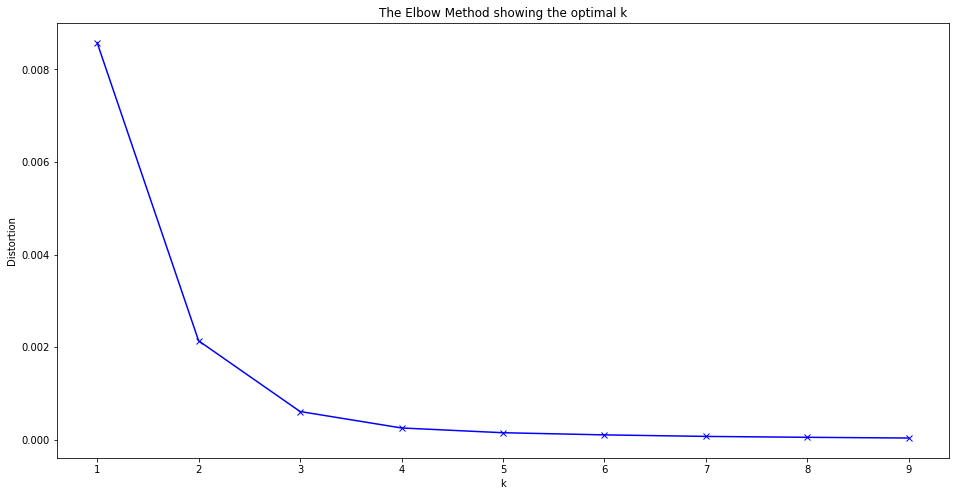

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [60]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop(['PostalCode', 'Borough', 'Neighborhoods', 'Church', 'Commerce',
       'Essential Retail', 'Fast Food', 'Hospital', 'Indoor Rec',
       'Indoor Venues', 'Licensed Establishment', 'Outdoor Rec',
       'Personal Services', 'Restaurant', 'Retail', 'Travel'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 0, 2, 3, 3, 0, 3])

In [62]:
kmeans.labels_

array([3, 3, 3, 3, 0, 2, 3, 3, 0, 3, 3, 2, 0, 0, 2, 1, 2, 2, 1, 0, 1, 1,
       2, 0, 0, 3, 0, 0, 1, 1, 3, 0, 3, 0, 3, 3, 3, 1])

In [63]:
toronto_df_new.tail()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
34,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763
35,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325
36,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
37,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


In [64]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_df_new.copy()
# drop last row


In [65]:
toronto_merged.drop(toronto_merged.tail(1).index, inplace=True)

In [66]:
# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_ #df.drop(df.tail(n).index,inplace=True) # drop last n rows

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(38, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Outdoor Rec,Licensed Establishment,Essential Retail,Travel,Retail,Restaurant,Personal Services,Indoor Venues,Indoor Rec,Hospital
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,3,Restaurant,Fast Food,Retail,Essential Retail,Licensed Establishment,Personal Services,Outdoor Rec,Indoor Rec,Travel,Indoor Venues
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,3,Fast Food,Restaurant,Licensed Establishment,Essential Retail,Travel,Retail,Outdoor Rec,Indoor Venues,Indoor Rec,Personal Services
3,M4M,East Toronto,Studio District,43.659526,-79.340923,3,Restaurant,Licensed Establishment,Fast Food,Essential Retail,Retail,Outdoor Rec,Indoor Rec,Commerce,Travel,Personal Services
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Travel,Outdoor Rec,Indoor Rec,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Hospital,Fast Food


In [67]:
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Outdoor Rec,Licensed Establishment,Essential Retail,Travel,Retail,Restaurant,Personal Services,Indoor Venues,Indoor Rec,Hospital
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,3,Restaurant,Fast Food,Retail,Essential Retail,Licensed Establishment,Personal Services,Outdoor Rec,Indoor Rec,Travel,Indoor Venues
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,3,Fast Food,Restaurant,Licensed Establishment,Essential Retail,Travel,Retail,Outdoor Rec,Indoor Venues,Indoor Rec,Personal Services
3,M4M,East Toronto,Studio District,43.659526,-79.340923,3,Restaurant,Licensed Establishment,Fast Food,Essential Retail,Retail,Outdoor Rec,Indoor Rec,Commerce,Travel,Personal Services
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Travel,Outdoor Rec,Indoor Rec,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Hospital,Fast Food
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,2,Indoor Rec,Travel,Retail,Restaurant,Outdoor Rec,Fast Food,Essential Retail,Personal Services,Licensed Establishment,Indoor Venues
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,3,Retail,Fast Food,Restaurant,Personal Services,Outdoor Rec,Indoor Rec,Travel,Licensed Establishment,Indoor Venues,Hospital
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,3,Fast Food,Restaurant,Essential Retail,Indoor Rec,Retail,Outdoor Rec,Licensed Establishment,Travel,Personal Services,Indoor Venues
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0,Outdoor Rec,Travel,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Indoor Rec,Hospital,Fast Food
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,3,Fast Food,Restaurant,Essential Retail,Travel,Licensed Establishment,Retail,Personal Services,Outdoor Rec,Indoor Venues,Indoor Rec


In [68]:
toronto_merged = toronto_merged.merge(cov_df, on='PostalCode')

In [69]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged.head()

(38, 17)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Positivity Rate
33,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,0,Fast Food,Restaurant,Essential Retail,Retail,Licensed Establishment,Indoor Venues,Indoor Rec,Travel,Personal Services,Outdoor Rec,0.03570
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,0,Essential Retail,Licensed Establishment,Retail,Restaurant,Outdoor Rec,Indoor Venues,Indoor Rec,Fast Food,Travel,Personal Services,0.03135
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Travel,Outdoor Rec,Indoor Rec,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Hospital,Fast Food,0.03335
27,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,0,Travel,Licensed Establishment,Retail,Outdoor Rec,Fast Food,Restaurant,Personal Services,Indoor Venues,Indoor Rec,Hospital,0.03620
26,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,0,Restaurant,Fast Food,Essential Retail,Licensed Establishment,Retail,Indoor Venues,Travel,Outdoor Rec,Hospital,Personal Services,0.04050


In [70]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [71]:
def venue_importance(Cluster):
    global res
    res = []
    for i in range(2,11):
        list_ = Cluster.iloc[:,i].tolist()
        for j in list_:
            res = res + [j]*(12-i)
    #print( res )
        
    




In [72]:
from collections import Counter
from wordcloud import WordCloud

def create_cloud(Cluster_range):
    word_cloud_dict=Counter(res)
    wordcloud = WordCloud(width = 1000, 
                          height = 500, 
                          prefer_horizontal = 0, 
                          background_color="white", 
                          relative_scaling = 0).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.title(label='Cluster with positivity rate range: '+str(Cluster_range) , fontsize = 20)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    #plt.savefig

#venue_importance(Cluster1)

In [73]:
# Cluster 1
Cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Cluster1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Positivity Rate
33,West Toronto,0,Fast Food,Restaurant,Essential Retail,Retail,Licensed Establishment,Indoor Venues,Indoor Rec,Travel,Personal Services,Outdoor Rec,0.03570
31,West Toronto,0,Essential Retail,Licensed Establishment,Retail,Restaurant,Outdoor Rec,Indoor Venues,Indoor Rec,Fast Food,Travel,Personal Services,0.03135
4,Central Toronto,0,Travel,Outdoor Rec,Indoor Rec,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Hospital,Fast Food,0.03335
27,Downtown Toronto,0,Travel,Licensed Establishment,Retail,Outdoor Rec,Fast Food,Restaurant,Personal Services,Indoor Venues,Indoor Rec,Hospital,0.03620
26,Downtown Toronto,0,Restaurant,Fast Food,Essential Retail,Licensed Establishment,Retail,Indoor Venues,Travel,Outdoor Rec,Hospital,Personal Services,0.04050
8,Central Toronto,0,Outdoor Rec,Travel,Retail,Restaurant,Personal Services,Licensed Establishment,Indoor Venues,Indoor Rec,Hospital,Fast Food,0.03535
24,Central Toronto,0,Fast Food,Restaurant,Essential Retail,Outdoor Rec,Licensed Establishment,Indoor Venues,Travel,Retail,Personal Services,Indoor Rec,0.03140
23,Central Toronto,0,Outdoor Rec,Retail,Restaurant,Travel,Personal Services,Licensed Establishment,Indoor Venues,Indoor Rec,Hospital,Fast Food,0.03420
12,Downtown Toronto,0,Restaurant,Fast Food,Licensed Establishment,Retail,Indoor Rec,Travel,Outdoor Rec,Essential Retail,Personal Services,Indoor Venues,0.03120
13,Downtown Toronto,0,Fast Food,Essential Retail,Restaurant,Indoor Venues,Retail,Outdoor Rec,Licensed Establishment,Indoor Rec,Travel,Personal Services,0.03720


In [74]:
Cluster1_range = [Cluster1['Positivity Rate'].min(), Cluster1['Positivity Rate'].max()]
Cluster1_range

[0.0312, 0.0405]

In [75]:
venue_importance(Cluster1)

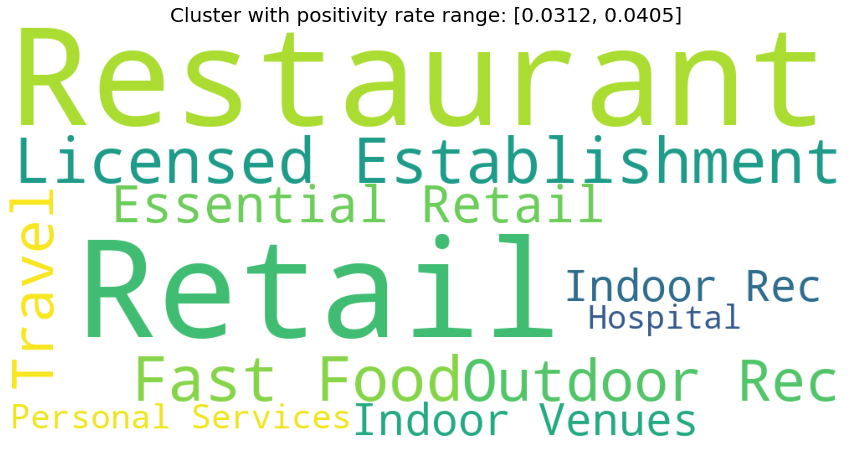

In [76]:
create_cloud(Cluster1_range)

In [77]:
#Cluster 2
Cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Cluster2_range = [Cluster2['Positivity Rate'].min(), Cluster2['Positivity Rate'].max()]
Cluster2_range

[0.0, 0.0]

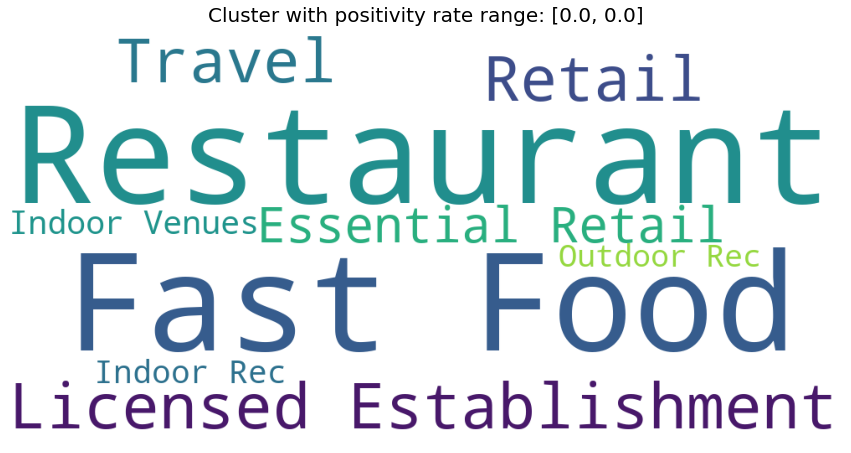

In [78]:
venue_importance(Cluster2)
create_cloud(Cluster2_range)

In [79]:
Cluster2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Positivity Rate
18,Downtown Toronto,1,Fast Food,Restaurant,Retail,Essential Retail,Licensed Establishment,Indoor Venues,Indoor Rec,Travel,Outdoor Rec,Personal Services,0.0
29,Downtown Toronto,1,Restaurant,Fast Food,Licensed Establishment,Travel,Indoor Venues,Indoor Rec,Essential Retail,Retail,Outdoor Rec,Personal Services,0.0
28,Downtown Toronto,1,Restaurant,Fast Food,Essential Retail,Licensed Establishment,Retail,Indoor Venues,Travel,Outdoor Rec,Indoor Rec,Personal Services,0.0
21,Downtown Toronto,1,Restaurant,Fast Food,Licensed Establishment,Travel,Retail,Indoor Rec,Essential Retail,Outdoor Rec,Indoor Venues,Personal Services,0.0
20,Downtown Toronto,1,Restaurant,Fast Food,Travel,Licensed Establishment,Indoor Venues,Retail,Essential Retail,Outdoor Rec,Indoor Rec,Personal Services,0.0
37,Downtown Toronto,1,Fast Food,Restaurant,Licensed Establishment,Indoor Venues,Indoor Rec,Travel,Outdoor Rec,Essential Retail,Retail,Personal Services,0.0
15,Downtown Toronto,1,Restaurant,Fast Food,Retail,Licensed Establishment,Essential Retail,Indoor Venues,Travel,Outdoor Rec,Indoor Rec,Personal Services,0.0


In [80]:
# Cluster 3
Cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Cluster3_range = [Cluster3['Positivity Rate'].min(), Cluster3['Positivity Rate'].max()]
Cluster3_range

[0.0442, 0.0537]

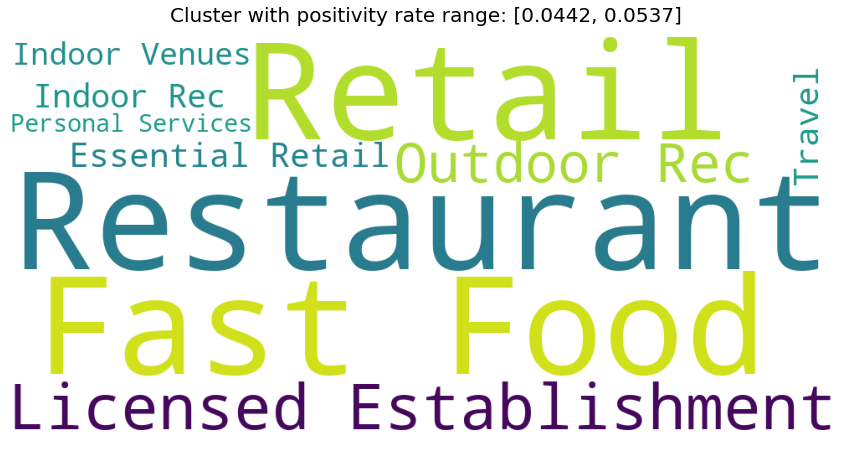

In [81]:
venue_importance(Cluster3)
create_cloud(Cluster3_range)

In [82]:
# Cluster 4
Cluster4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
Cluster4_range = [Cluster4['Positivity Rate'].min(), Cluster4['Positivity Rate'].max()]
Cluster4_range

[0.0193, 0.02985]

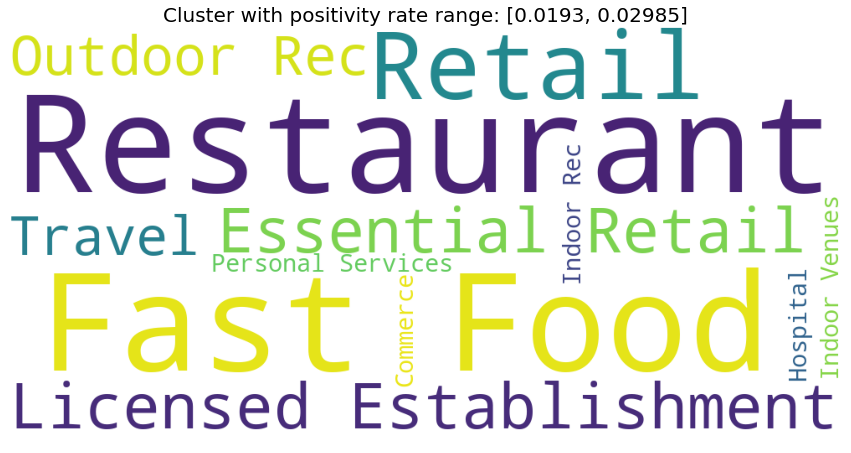

In [83]:
venue_importance(Cluster4)
create_cloud(Cluster4_range)

In [84]:
toronto_grouped.head()

,PostalCode,Borough,Neighborhoods,Church,Commerce,Essential Retail,Fast Food,Hospital,Indoor Rec,Indoor Venues,Licensed Establishment,Outdoor Rec,Personal Services,Restaurant,Retail,Travel,Positivity Rate
0,M4E,East Toronto,The Beaches,0.0,0.000000,0.250000,0.000000,0.0,0.000000,0.000000,0.250000,0.500000,0.00000,0.000000,0.000000,0.000000,0.02900
1,M4K,East Toronto,"The Danforth West, Riverdale",0.0,0.000000,0.095238,0.285714,0.0,0.023810,0.000000,0.071429,0.023810,0.02381,0.380952,0.095238,0.000000,0.02660
2,M4L,East Toronto,"India Bazaar, The Beaches West",0.0,0.000000,0.095238,0.380952,0.0,0.047619,0.047619,0.095238,0.047619,0.00000,0.190476,0.047619,0.047619,0.02340
3,M4M,East Toronto,Studio District,0.0,0.027778,0.166667,0.166667,0.0,0.055556,0.000000,0.166667,0.055556,0.00000,0.250000,0.111111,0.000000,0.02695
4,M4N,Central Toronto,Lawrence Park,0.0,0.000000,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.333333,0.00000,0.000000,0.000000,0.333333,0.03335


In [85]:
toronto_grouped_data = toronto_grouped.iloc[:,3:17]
toronto_grouped_data

,Church,Commerce,Essential Retail,Fast Food,Hospital,Indoor Rec,Indoor Venues,Licensed Establishment,Outdoor Rec,Personal Services,Restaurant,Retail,Travel,Positivity Rate
0,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000,0.000000,0.000000,0.02900
1,0.000000,0.000000,0.095238,0.285714,0.000000,0.023810,0.000000,0.071429,0.023810,0.023810,0.380952,0.095238,0.000000,0.02660
2,0.000000,0.000000,0.095238,0.380952,0.000000,0.047619,0.047619,0.095238,0.047619,0.000000,0.190476,0.047619,0.047619,0.02340
3,0.000000,0.027778,0.166667,0.166667,0.000000,0.055556,0.000000,0.166667,0.055556,0.000000,0.250000,0.111111,0.000000,0.02695
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.03335
5,0.000000,0.000000,0.125000,0.125000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.04620
6,0.000000,0.000000,0.000000,0.263158,0.000000,0.052632,0.000000,0.000000,0.052632,0.105263,0.210526,0.315789,0.000000,0.02700
7,0.000000,0.000000,0.114286,0.400000,0.000000,0.085714,0.000000,0.028571,0.028571,0.000000,0.285714,0.057143,0.000000,0.02800
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.03535
9,0.000000,0.000000,0.214286,0.357143,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.285714,0.000000,0.071429,0.02875


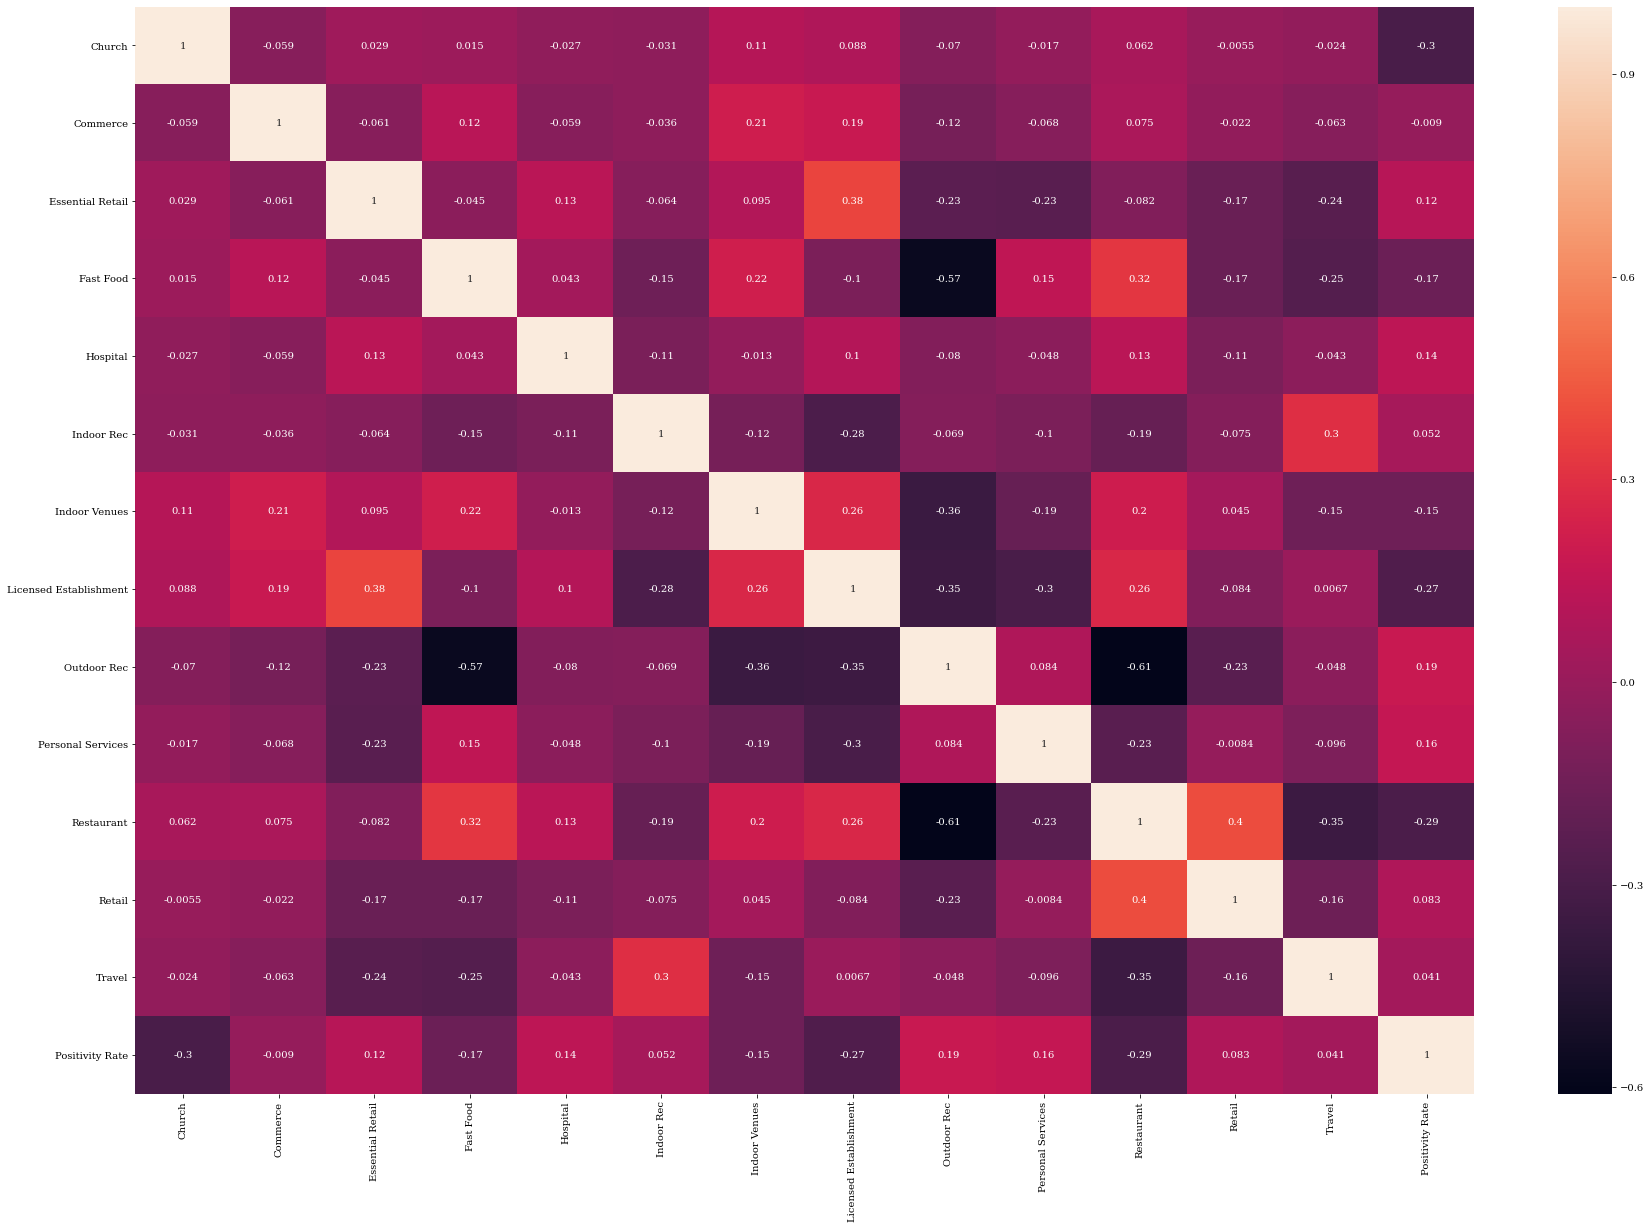

In [120]:
import seaborn as sn

corrMatrix = toronto_grouped_data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.rcParams['figure.figsize'] = (30.0, 20.0)
plt.rcParams['font.family'] = "serif"
plt.show()

In [87]:
X = toronto_grouped_data.iloc[:, 0:-2].values
y = toronto_grouped_data.iloc[:, -1].values

In [88]:
# Fitting Random Forest Regression to the dataset 
# import the regressor 
from sklearn.ensemble import RandomForestRegressor 
  
 # create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 42) 
  
# fit the regressor 
regressor.fit(X, y)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [89]:
regressor.score(X,y)

0.8531403820670297

In [90]:
toronto_grouped_data_new = toronto_grouped_data[toronto_grouped_data['Positivity Rate'] > 0]
toronto_grouped_data_new.reset_index
toronto_grouped_data_new

,Church,Commerce,Essential Retail,Fast Food,Hospital,Indoor Rec,Indoor Venues,Licensed Establishment,Outdoor Rec,Personal Services,Restaurant,Retail,Travel,Positivity Rate
0,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000,0.000000,0.000000,0.02900
1,0.0,0.000000,0.095238,0.285714,0.000000,0.023810,0.000000,0.071429,0.023810,0.023810,0.380952,0.095238,0.000000,0.02660
2,0.0,0.000000,0.095238,0.380952,0.000000,0.047619,0.047619,0.095238,0.047619,0.000000,0.190476,0.047619,0.047619,0.02340
3,0.0,0.027778,0.166667,0.166667,0.000000,0.055556,0.000000,0.166667,0.055556,0.000000,0.250000,0.111111,0.000000,0.02695
4,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.03335
5,0.0,0.000000,0.125000,0.125000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.04620
6,0.0,0.000000,0.000000,0.263158,0.000000,0.052632,0.000000,0.000000,0.052632,0.105263,0.210526,0.315789,0.000000,0.02700
7,0.0,0.000000,0.114286,0.400000,0.000000,0.085714,0.000000,0.028571,0.028571,0.000000,0.285714,0.057143,0.000000,0.02800
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.03535
9,0.0,0.000000,0.214286,0.357143,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.285714,0.000000,0.071429,0.02875


In [91]:
toronto_grouped_data_new = toronto_grouped_data_new.drop(columns = 'Church')
toronto_grouped_data_new

,Commerce,Essential Retail,Fast Food,Hospital,Indoor Rec,Indoor Venues,Licensed Establishment,Outdoor Rec,Personal Services,Restaurant,Retail,Travel,Positivity Rate
0,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000,0.000000,0.000000,0.02900
1,0.000000,0.095238,0.285714,0.000000,0.023810,0.000000,0.071429,0.023810,0.023810,0.380952,0.095238,0.000000,0.02660
2,0.000000,0.095238,0.380952,0.000000,0.047619,0.047619,0.095238,0.047619,0.000000,0.190476,0.047619,0.047619,0.02340
3,0.027778,0.166667,0.166667,0.000000,0.055556,0.000000,0.166667,0.055556,0.000000,0.250000,0.111111,0.000000,0.02695
4,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.03335
5,0.000000,0.125000,0.125000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.04620
6,0.000000,0.000000,0.263158,0.000000,0.052632,0.000000,0.000000,0.052632,0.105263,0.210526,0.315789,0.000000,0.02700
7,0.000000,0.114286,0.400000,0.000000,0.085714,0.000000,0.028571,0.028571,0.000000,0.285714,0.057143,0.000000,0.02800
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.03535
9,0.000000,0.214286,0.357143,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.285714,0.000000,0.071429,0.02875


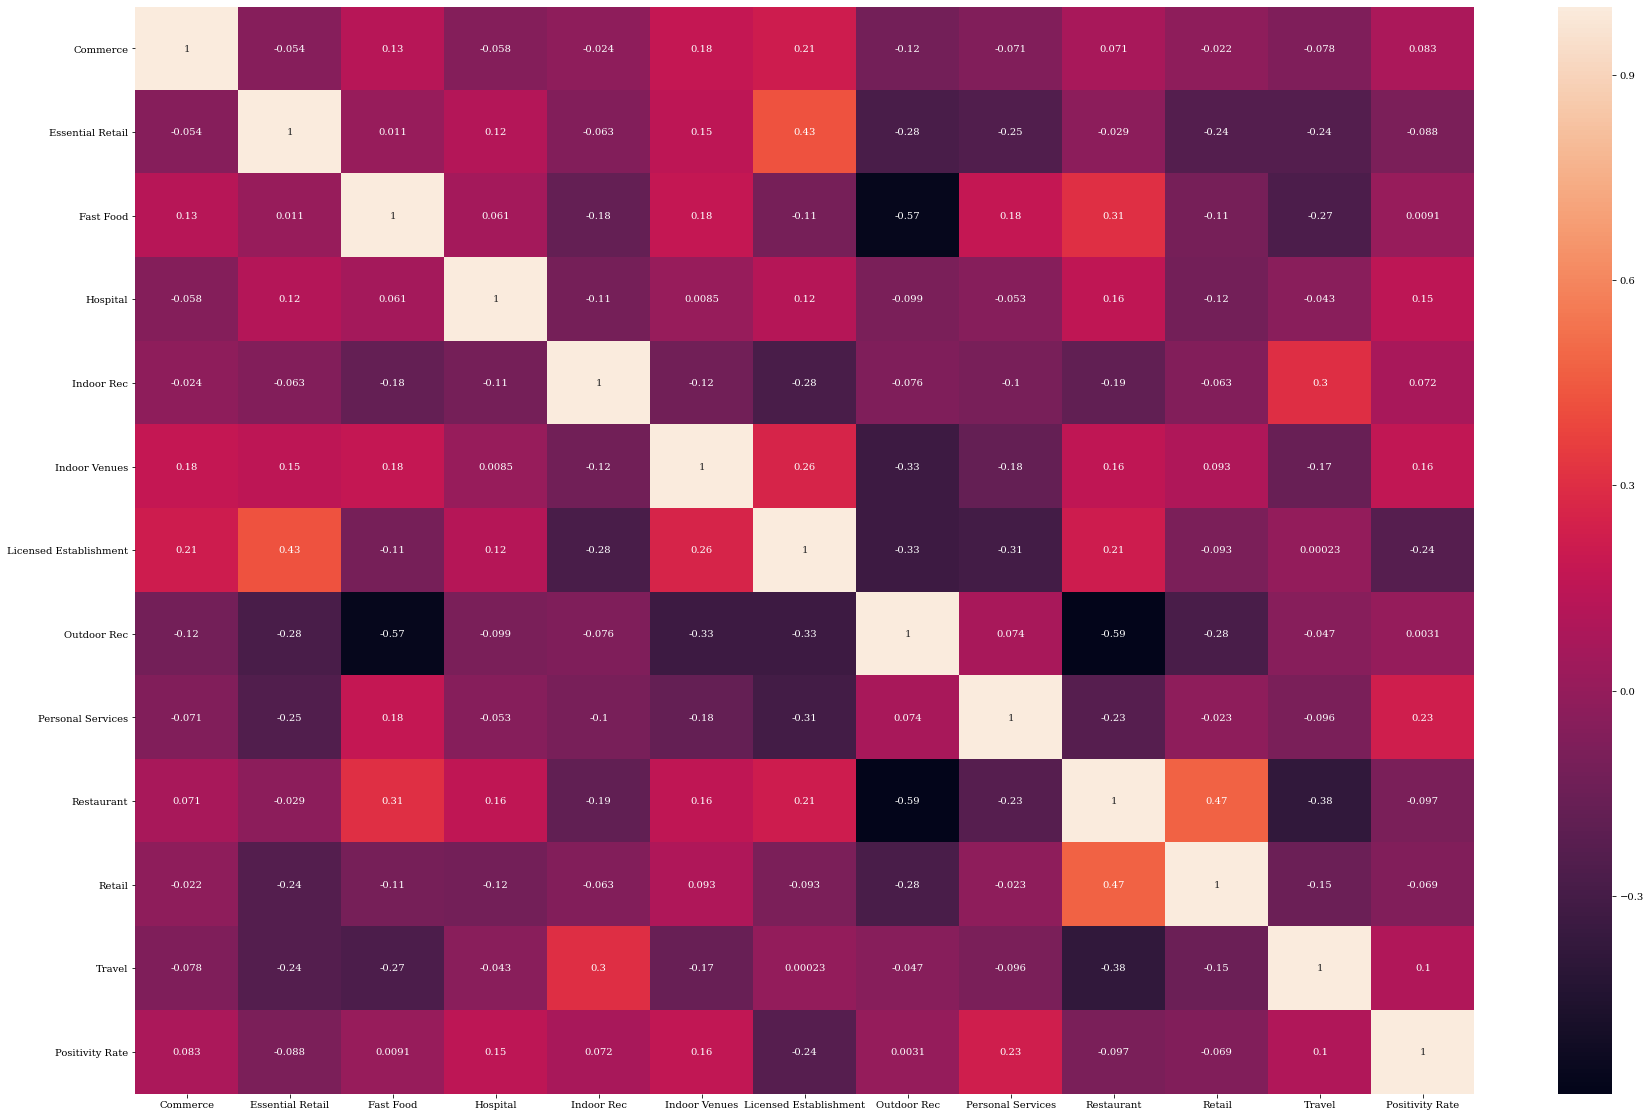

In [92]:
corrMatrix = toronto_grouped_data_new.corr()
sn.heatmap(corrMatrix, annot=True)
plt.rcParams['figure.figsize'] = (30.0, 20.0)
plt.rcParams['font.family'] = "serif"
plt.show()